In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but!pip install mne mlxtend -q

/kaggle/input/ratz-dataset/data_all.csv


In [41]:
!pip install mne mlxtend -q
!pip install --upgrade tensorflow tf-keras -q
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from keras.metrics import Recall
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [42]:
data = pd.read_csv('/kaggle/input/ratz-dataset/data_all.csv', index_col=0)

In [43]:
# _none = df[df['marker']=='none'].head(235640).copy()
# _ds = df[df['marker']=='ds'].head(235640).copy()
# _swd = df[df['marker']=='swd'].head(235640).copy()
# _is = df[df['marker']=='is'].copy()

# balanced_data = pd.DataFrame()
# balanced_data = pd.concat([_none, _ds, _swd, _is], ignore_index=True)
# balanced_data = pd.concat([_ds, _swd, _is], ignore_index=True)
# balanced_data.shape
balanced_data = data

In [44]:
test_krisa = 5

label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['marker'])

test_data = balanced_data[balanced_data['krisa'] == test_krisa]
train_data = balanced_data[balanced_data['krisa'] != test_krisa]

del data, balanced_data

X_train = train_data.drop(columns=['marker', 'time', 'krisa', 'label'], axis=1)
y_train = train_data['label']
X_test = test_data.drop(columns=['marker', 'time', 'krisa', 'label'], axis=1)
y_test = test_data['label']

del test_data, train_data

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [45]:
label.classes_

array(['ds', 'is', 'none', 'swd'], dtype=object)

In [46]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train = pd.DataFrame(data = X_train, columns = ['FrL', 'FrR', 'OcR'])
X_test = pd.DataFrame(data = X_test, columns = ['FrL', 'FrR', 'OcR'])

In [47]:
N_FEATURES = 3
def get_frames(df, frame_size, hop_size):
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        frl = df['FrL'].values[i: i + frame_size]
        frr = df['FrR'].values[i: i + frame_size]
        ocr = df['OcR'].values[i: i + frame_size]

        # Retrieve the most frequent label in this segment
        mode_result = stats.mode(df['label'][i: i + frame_size], axis=None)

        # Handle the case where the mode result is a scalar
        label = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

        frames.append([frl, frr, ocr])
        labels.append(label)

    # Reshape frames and labels for model input
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [48]:
Fs = 400
frame_size = Fs*10
hop_size = Fs*3

X_train, y_train = get_frames(pd.concat([X_train, y_train], axis=1), frame_size, hop_size)
X_test, y_test = get_frames(pd.concat([X_test, y_test], axis=1), frame_size, hop_size)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35999, 4000, 3), (35999,), (7198, 4000, 3), (7198,))

In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0], 3, 1)
X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0], 3, 1)

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35999, 4000, 3, 1), (35999,), (7198, 4000, 3, 1), (7198,))

In [51]:
model = Sequential([
    Conv2D(16, (2, 2), activation='relu'),
    Dropout(0.1),
    Conv2D(32, (2, 2), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [52]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9446572898079143,
 1: 44.11642156862745,
 2: 0.3460111495578624,
 3: 34.882751937984494}

In [53]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [54]:
history = model.fit(X_train, y_train, epochs = 15, validation_data=(X_test, y_test), verbose=1, class_weight=class_weights)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - accuracy: 0.2682 - loss: 2.4635 - val_accuracy: 0.3990 - val_loss: 1.0190
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5927 - loss: 0.8054 - val_accuracy: 0.7248 - val_loss: 1.0739
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.5874 - loss: 0.6279 - val_accuracy: 0.7617 - val_loss: 1.2722
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.6629 - loss: 0.5203 - val_accuracy: 0.7234 - val_loss: 1.2167
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.6481 - loss: 0.5640 - val_accuracy: 0.7688 - val_loss: 1.0985
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.6955 - loss: 0.5215 - val_accuracy: 0.7587 - val_loss: 0.9151
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.6591 - loss: 0.7014 - val_accuracy: 0.7356 - val_loss: 0.9573
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.7091 -

In [55]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.734787440955821
Precision: 0.5414041088336553
Recall: 0.3771542855721547


In [ ]:
while True: pass

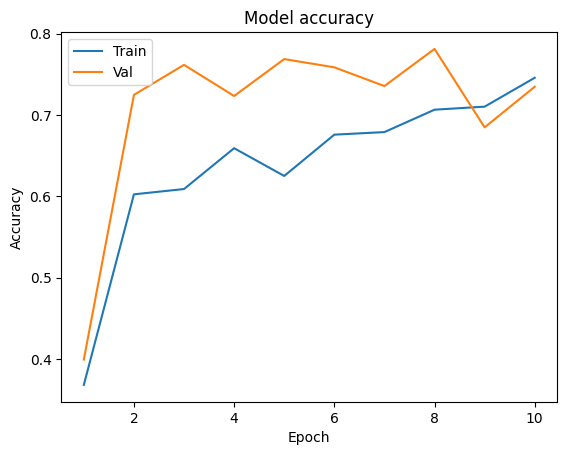

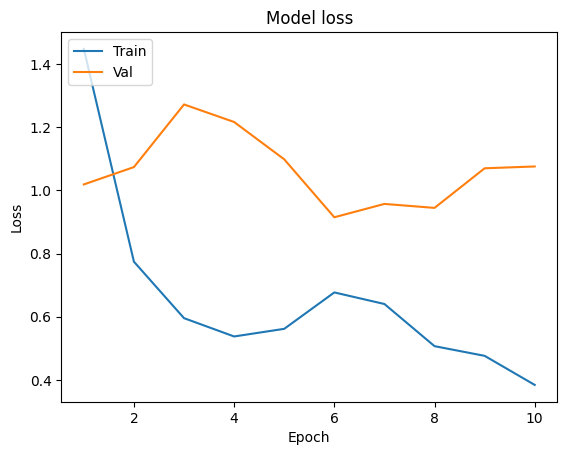

In [57]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 10)

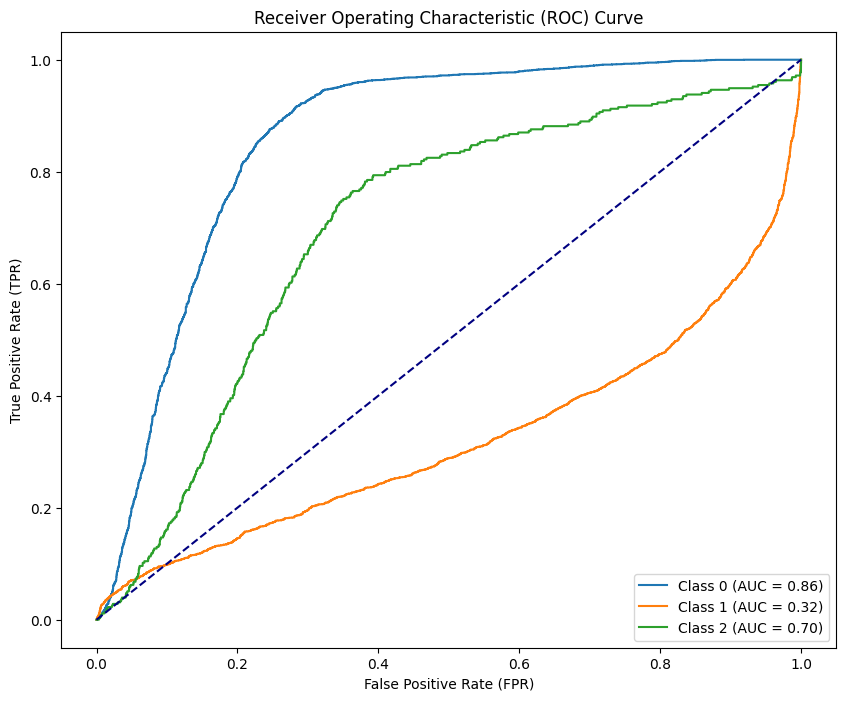

In [58]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

In [60]:
model.save('model_acc73_prc54_rec38.keras')